# Actinometry

## Load Experimental Actinometry Data

We begin by importing the required library and loading the actinometry measurement data from a CSV file. The dataset is stored in `exp_data` for further analysis


In [1]:
import pandas as pd  # Import the pandas library for data handling

# Load the actinometry experiment data from the specified CSV file
exp_data = pd.read_csv("DATA/DAE.csv")

exp_data  # Display the loaded dataset

timestamp  cycle    type  186.85486  187.31995223015844  \
0    2025-04-04 11:29:32.797890      1    zero  16.990556        24978.543889   
1    2025-04-04 11:31:06.034842      1      on  16.990556        24978.543889   
2    2025-04-04 11:31:07.075687      1      on  16.990556        24978.543889   
3    2025-04-04 11:31:08.109308      1      on  16.990556        24978.543889   
4    2025-04-04 11:31:09.153691      1      on  16.990556        24978.543889   
..                          ...    ...     ...        ...                 ...   
614  2025-04-04 11:41:43.804611      1      on  16.990556        24978.543889   
615  2025-04-04 11:41:44.858569      1      on  16.990556        24978.543889   
616  2025-04-04 11:41:45.888795      1      on  16.990556        24978.543889   
617  2025-04-04 11:41:46.925455      1      on  16.990556        24978.543889   
618  2025-04-04 11:41:59.961864      1  static  16.990556        24978.543889   

     187.78500323297956  188.250012996982  188.71498151068454  \
0            249.154361        241.872694          253.523361   
1            254.858333        231.395185          276.163951   
2            240.025309        238.676852          256.206790   
3            242.991914        246.767593          242.182840   
4            241.643457        222.765062          271.039815   
..                  ...               ...                 ...   
614          241.913148        236.789012          220.337840   
615          212.786481        231.125494          234.361790   
616          223.304444        240.564691          237.058704   
617          232.204259        234.631481          235.170864   
618          225.488944        217.964556          231.557000   

     189.17990876260572  189.64479474126426  ...  1032.9632529736894  \
0            243.935833          258.499167  ...          652.315972   
1            261.600617          252.431111  ...          639.168519   
2            239.755617          265.106605  ...          653.192469   
3            280.479012          280.748704  ...          637.820062   
4            262.140000          255.667407  ...          652.113704   
..                  ...                 ...  ...                 ...   
614          231.934568          246.767593  ...          649.686481   
615          239.755617          265.106605  ...          638.089753   
616          251.622037          240.295000  ...          659.125679   
617          257.824938          243.800988  ...          621.368889   
618          247.455306          278.281028  ...          634.475889   

     1033.3204920667242  1033.6776665334785  1034.034776362471  \
0            654.500472          655.471361         647.218806   
1            672.070864          642.944198         664.789198   
2            652.922778          643.483580         663.710432   
3            659.665062          663.440741         645.641111   
4            651.844012          651.574321         651.034938   
..                  ...                 ...                ...   
614          641.326049          641.865432         641.865432   
615          626.762716          630.268704         636.201914   
616          635.392840          641.056358         646.719877   
617          644.292654          632.156543         629.459630   
618          630.228250          649.888750         648.675139   

     1034.3918215422202  1034.7488020612445  1035.1057179080635  \
0            664.694806          659.354917          666.151139   
1            651.034938          650.495556          633.235309   
2            668.834568          634.853457          628.111173   
3            635.662531          629.189938          638.359444   
4            648.877407          647.528951          638.629136   
..                  ...                 ...                 ...   
614          641.056358          645.371420          639.438210   
615          634.853457          648.068333          654.001543   
616    

## Preprocess Spectral Data and Compute Absorbance

We now prepare the spectral intensity data for analysis. The dataset contains different types of measurements:
- **"zero"**: baseline measurements,
- **"static"**: background noise or dark reference,
- **Other types**: actual actinometry measurements over time.

We extract these components, convert timestamps, and compute the absorbance spectrum using the formula:

$$A(\lambda) = -\log_{10} \left( \frac{I(\lambda) - I_{\text{static}}(\lambda)}{I_{\text{zero}}(\lambda) - I_{\text{static}}(\lambda)} \right)$$

This normalization corrects for both dark current and reference intensity variations.


In [2]:
import numpy as np  # NumPy for numerical operations

# Extract intensity data excluding 'zero' and 'static' types
intensities = np.array(
    exp_data[(exp_data["type"] != "zero") & (exp_data["type"] != "static")].iloc[:, 3:], 
    dtype=np.float64
)

# Extract static (dark) reference spectrum
static = np.array(
    exp_data[exp_data["type"] == "static"].iloc[:, 3:], 
    dtype=np.float64
)[0]

# Extract zero (reference light) spectrum
zero = np.array(
    exp_data[exp_data["type"] == "zero"].iloc[:, 3:], 
    dtype=np.float64
)[0]

# Extract wavelengths from column names (assuming columns 3+ are spectral data)
wavelengths = np.array(exp_data.columns[3:], dtype=np.float64)

# Convert timestamp strings to seconds since the first measurement
timestamps = pd.to_datetime(
    exp_data["timestamp"][(exp_data["type"] != "zero") & (exp_data["type"] != "static")]
)
timestamps = np.array((timestamps - timestamps.iloc[0]).dt.total_seconds())

# Function to compute absorbance spectrum
def compute_absorbance(intensities: np.ndarray, static: np.ndarray, zero: np.ndarray) -> np.ndarray:
    EPS = 1e-12  # Small epsilon to avoid division by zero or log of zero
    num = intensities - static
    den = np.maximum(zero - static, EPS)  # Ensure denominator is not zero
    absorbance = -np.log10(np.maximum(num / den, EPS))  # Log transform with safety check
    return absorbance

# Calculate absorbance for each measurement
absorbance = compute_absorbance(intensities, static, zero)


## Visualizing Spectral Intensity and Absorbance

This figure provides a comprehensive view of the actinometry data:

1. **Left Panel**: Raw intensity spectra at three time points, along with the static and zero references.
2. **Middle Panel**: Corresponding absorbance spectra at the same time points, showing how absorption evolves over time.
3. **Right Panel**: Absorbance at two key wavelengths (505 nm and 562 nm) plotted as a function of time, highlighting dynamic changes in the sample.

These plots help assess the stability and dynamics of the measured signals and the quality of the zero/static references.


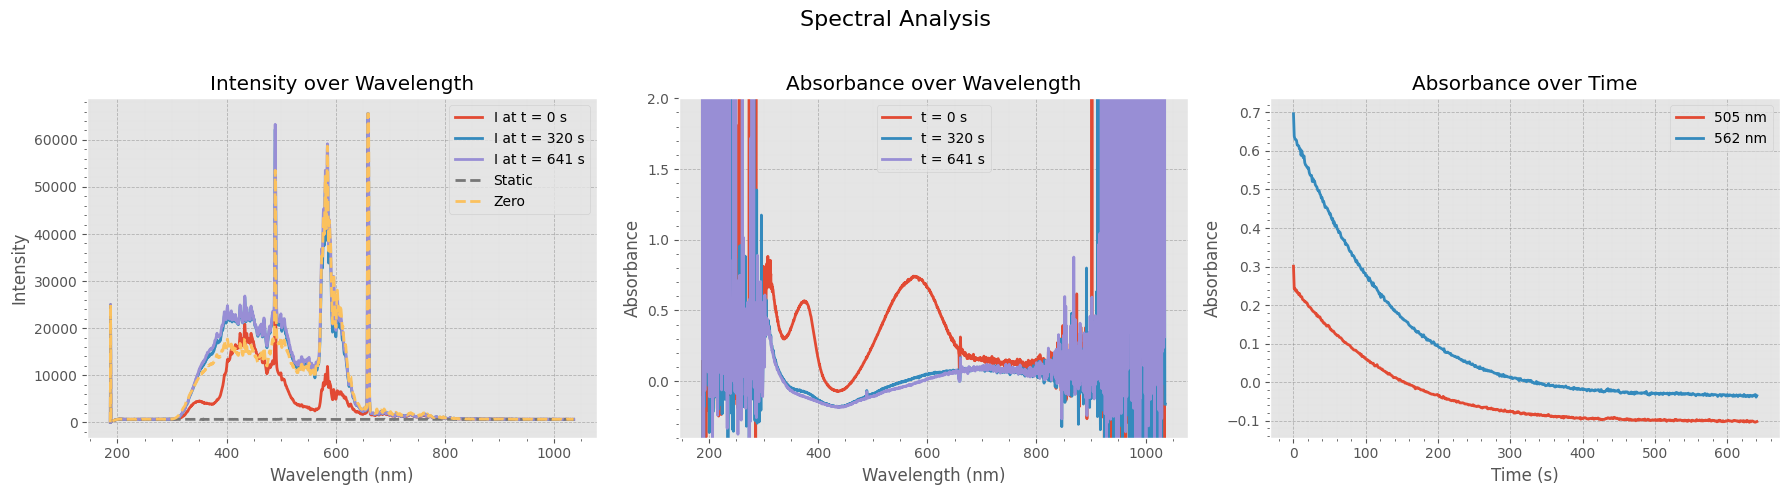

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Use a clean, readable plotting style
plt.style.use("ggplot")

# Set up a figure with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Spectral Analysis", fontsize=16)

# === Plot 1: Raw Intensities ===
# Show intensity at beginning, middle, and end of acquisition
axs[0].plot(wavelengths, intensities[0, :], label=f"I at t = {timestamps[0]:.0f} s", linewidth=2)
axs[0].plot(wavelengths, intensities[len(intensities)//2, :], label=f"I at t = {timestamps[len(intensities)//2]:.0f} s", linewidth=2)
axs[0].plot(wavelengths, intensities[-1, :], label=f"I at t = {timestamps[-1]:.0f} s", linewidth=2)

# Add static and zero reference spectra for comparison
axs[0].plot(wavelengths, static, '--', label="Static", linewidth=2)
axs[0].plot(wavelengths, zero, '--', label="Zero", linewidth=2)

axs[0].set_title("Intensity over Wavelength")
axs[0].set_xlabel("Wavelength (nm)")
axs[0].set_ylabel("Intensity")
axs[0].legend()

# Add major and minor grid for clarity
axs[0].grid(True, which='major', linestyle='--', linewidth=0.6, color='gray', alpha=0.5, zorder=0)
axs[0].minorticks_on()
axs[0].grid(True, which='minor', linestyle=':', linewidth=0.3, color='lightgray', alpha=0.4, zorder=0)

# === Plot 2: Absorbance Spectra ===
# Show absorbance at beginning, middle, and end of acquisition
axs[1].plot(wavelengths, absorbance[0, :], label=f"t = {timestamps[0]:.0f} s", linewidth=2)
axs[1].plot(wavelengths, absorbance[len(absorbance)//2, :], label=f"t = {timestamps[len(absorbance)//2]:.0f} s", linewidth=2)
axs[1].plot(wavelengths, absorbance[-1, :], label=f"t = {timestamps[-1]:.0f} s", linewidth=2)

axs[1].set_title("Absorbance over Wavelength")
axs[1].set_xlabel("Wavelength (nm)")
axs[1].set_ylabel("Absorbance")
axs[1].set_ylim(-0.4, 2)
axs[1].legend()

# Grid setup
axs[1].grid(True, which='major', linestyle='--', linewidth=0.6, color='gray', alpha=0.5, zorder=0)
axs[1].minorticks_on()
axs[1].grid(True, which='minor', linestyle=':', linewidth=0.3, color='lightgray', alpha=0.4, zorder=0)

# === Plot 3: Absorbance vs Time at Key Wavelengths ===
# Choose wavelengths of interest (e.g. peaks)
WL = [505, 562]
idxs = [np.argmin(np.abs(wavelengths - wl)) for wl in WL]  # Find closest actual wavelength index

# Plot absorbance vs time for selected wavelengths
for i, idx in enumerate(idxs):
    axs[2].plot(timestamps, absorbance[:, idx], label=f"{wavelengths[idx]:.0f} nm", linewidth=2)

axs[2].set_title("Absorbance over Time")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Absorbance")
axs[2].legend()

# Grid setup
axs[2].grid(True, which='major', linestyle='--', linewidth=0.6, color='gray', alpha=0.5, zorder=0)
axs[2].minorticks_on()
axs[2].grid(True, which='minor', linestyle=':', linewidth=0.3, color='lightgray', alpha=0.4, zorder=0)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Data Cleaning and Absorbance Subset Preparation

This cell prepares the dataset for focused analysis by:

- Selecting a narrow wavelength range (e.g. 560–565 nm)
- Normalizing absorbance values
- Removing unwanted time points (first spectrum and last 300)

The resulting cleaned subset is suitable for targeted visualization or kinetic analysis.


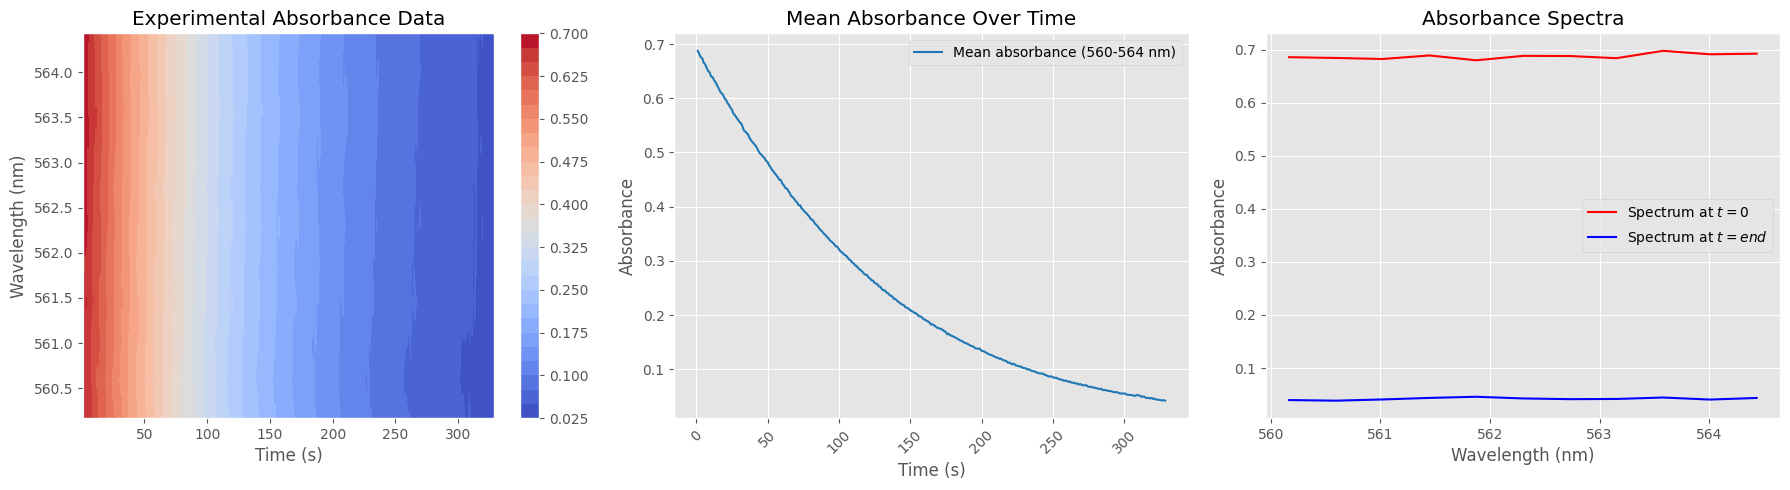

In [4]:
# === USER PARAMETERS ===
wavelength_range = [560, 565]  # Wavelength range of interest (nm)
remove_first = True            # Whether to remove the first time point
remove_last_n = 300            # Number of last time points to remove
time_filter_indices = [0] + list(range(-300, 0))

# === Select wavelength index range ===
idx_range = np.argmin(np.abs(wavelengths[:, None] - wavelength_range), axis=0)

# Extract absorbance data in selected range
absorbance_subset = absorbance[:, idx_range[0]:idx_range[1]]
absorbance_subset -= np.min(absorbance_subset)  # Normalize (set min to 0)

# Corresponding wavelengths
wavelengths_subset = wavelengths[idx_range[0]:idx_range[1]]

# === Filter time points ===
# Build index list for rows to remove

# Apply filtering
absorbance_subset = np.delete(absorbance_subset, time_filter_indices, axis=0)
timestamps_filtered = np.delete(timestamps, time_filter_indices)



# --- Create 3 plots ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# === 1. Heatmap of absorbance over time and wavelength ===
X, Y = np.meshgrid(timestamps_filtered, wavelengths_subset)  # Create grids for contour plot
contour = axs[0].contourf(X, Y, absorbance_subset.T, levels=30, cmap="coolwarm")
axs[0].set_title("Experimental Absorbance Data")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Wavelength (nm)")
fig.colorbar(contour, ax=axs[0])  # Add colorbar to show absorbance scale

# === 2. Mean absorbance over time ===
mean_absorbance = np.mean(absorbance_subset, axis=1)
axs[1].plot(timestamps_filtered, mean_absorbance,
            label=f"Mean absorbance ({wavelengths_subset[0]:.0f}-{wavelengths_subset[-1]:.0f} nm)",
            color='tab:blue')
axs[1].set_title("Mean Absorbance Over Time")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Absorbance")
axs[1].tick_params(axis="x", rotation=45)
axs[1].legend()
axs[1].grid(True)

# === 3. Compare start and end absorbance spectra ===
axs[2].plot(wavelengths_subset, absorbance_subset[0, :], label="Spectrum at $t=0$", color='red')
axs[2].plot(wavelengths_subset, absorbance_subset[-1, :], label="Spectrum at $t=end$", color='blue')
axs[2].set_title("Absorbance Spectra")
axs[2].set_xlabel("Wavelength (nm)")
axs[2].set_ylabel("Absorbance")
axs[2].legend()
axs[2].grid(True)

# Improve layout spacing
plt.tight_layout()
plt.show()

## Kinetic Modeling and LED Power Estimation

This section fits the photokinetics model to the experimental concentration curve derived from absorbance data, to estimate the effective LED power.

- Assumes first-order photon absorption
- Uses `scipy.integrate.solve_ivp` for integration
- Fits using `curve_fit` with LED power as a free parameter


Quantum Yield (QY_CF2OF): 0.0235
=== Starting curve fit ===

=== Fit Results ===
I_w (W): 0.010431 ± 0.000024
Offset (M): 0.000000 ± 0.000000


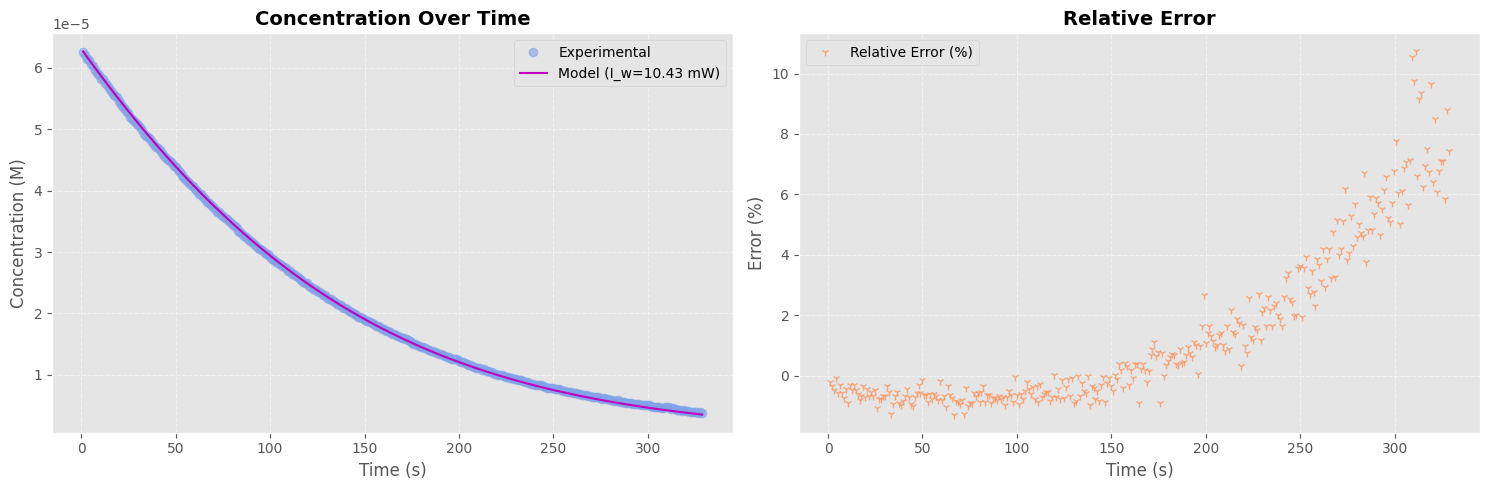

In [5]:
# === USER PARAMETERS ===
wl = 505  # nm (LED wavelength)
volume = 14e-4  # L
l = 1  # cm (optical path length)
eps_closed_505 = 0.6e4  # M^-1.cm^-1
eps_closed_562 = 1.1e4  # M^-1.cm^-1
I_w_initial_guess = 14.27e-3  # Initial guess (W)
QY_CF2OF = np.power(10, -2.67 + 526 / wl)  # Quantum yield estimation from literature

print(f"Quantum Yield (QY_CF2OF): {QY_CF2OF:.4f}")

from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# === Physics constants ===
h = 6.62607004e-34  # Planck constant (J.s)
NA = 6.02214086e23  # Avogadro number (mol^-1)
c_vacuum = 299792458  # m/s
v = c_vacuum / (wl * 1e-9)  # Frequency (Hz)

# === Experimental concentration from absorbance ===
C_exp = mean_absorbance / (eps_closed_562 * l)
C0 = C_exp[0]

# === ODE definition ===
def dC_dt(t, C_closed, I_w):
    I_0 = I_w / (h * v * NA) / volume  # Photon flux [mol photons / L]
    I_abs = I_0 * (1 - np.exp(-eps_closed_505 * C_closed * l * np.log(10)))
    return -QY_CF2OF * I_abs

# === Fitting function wrapper ===
def model(t, I_w, offset):
    sol = solve_ivp(dC_dt, [t[0], t[-1]], [C0], t_eval=t, args=(I_w,))
    if not sol.success:
        print("⚠️ ODE solver failed:", sol.message)
        return np.full_like(t, np.nan)
    return sol.y[0] + offset

# === Fit parameters ===
initial_guess = (I_w_initial_guess, 0)
bounds = ([0, -1], [100e-3, 1])  # Bounds for I_w and offset

print("=== Starting curve fit ===")
popt, pcov = curve_fit(model, timestamps_filtered, C_exp, p0=initial_guess, bounds=bounds)
uncertainties = np.sqrt(np.diag(pcov))

# === Report fitted parameters ===
print("\n=== Fit Results ===")
params = ["I_w (W)", "Offset (M)"]
for name, val, err in zip(params, popt, uncertainties):
    print(f"{name}: {val:.6f} ± {err:.6f}")

# === Compute fitted curve ===
fitted_values = model(timestamps_filtered, *popt)

# === Plotting ===
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
colors = ["#81a3e8", "#f9955e", "m"]

# Plot: Concentration vs Time
axs[0].plot(timestamps_filtered, C_exp, "o", color=colors[0], label="Experimental", alpha=0.6)
axs[0].plot(timestamps_filtered, fitted_values, "-", color=colors[2], label=f"Model (I_w={popt[0]*1e3:.2f} mW)")
axs[0].set_title("Concentration Over Time", fontsize=14, fontweight="bold")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Concentration (M)")
axs[0].grid(True, linestyle="--", alpha=0.5)
axs[0].legend()

# Plot: Relative Error
relative_error = (C_exp - fitted_values) * 100 / C_exp
axs[1].plot(timestamps_filtered, relative_error, "1", color=colors[1], label="Relative Error (%)", alpha=0.8)
axs[1].set_title("Relative Error", fontsize=14, fontweight="bold")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Error (%)")
axs[1].grid(True, linestyle="--", alpha=0.5)
axs[1].legend()

plt.tight_layout()
plt.show()
